### Import necessary modules

In [4]:
import os
import sys
from IPython.display import display, Image
sys.path.insert(0, os.path.abspath('./utils'))
import get_time_series as gts
import geopandas
# import importlib
# importlib.reload(gts)

### Define parameters and extract profiles with the RESTful services

<Response [200]>
http://185.178.85.7/query/parcelById?aoi=cz&year=2019&pid=767110201/3&withGeometry=True
767110201/3 Permanent grassland s2 area:19.54
<Response [200]>
http://185.178.85.7/query/parcelTimeSeries?aoi=cz&year=2019&pid=767110201/3&tstype=s2&scl=True&ref=True
NDVI graph saved to file: e:/munka/outreach_2021/CZ/mowing_detection/ndvi_graphs/all_parcels/767110201-3.jpg


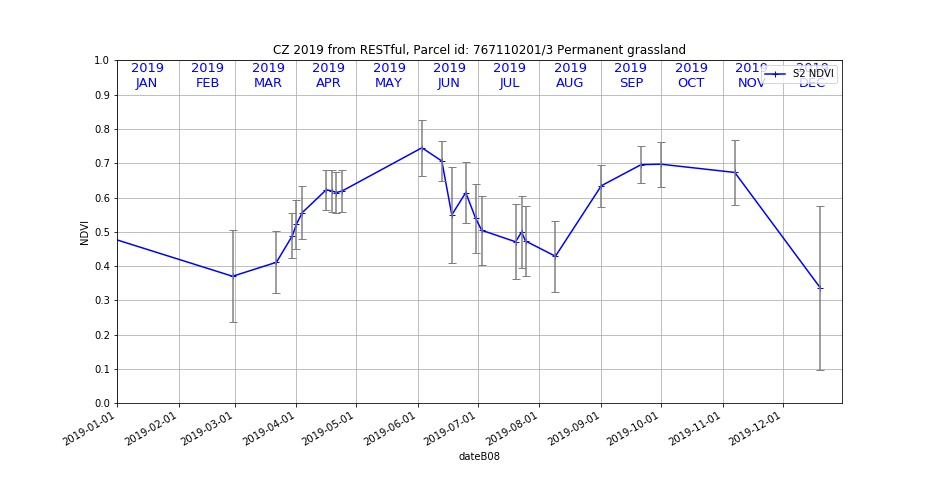

<Response [200]>
http://185.178.85.7/query/parcelById?aoi=cz&year=2019&pid=767110201/3&withGeometry=True
767110201/3 Permanent grassland c6 area:19.54
<Response [200]>
http://185.178.85.7/query/parcelTimeSeries?aoi=cz&year=2019&pid=767110201/3&tstype=c6&scl=True&ref=True
COH6 graph saved to file: e:/munka/outreach_2021/CZ/mowing_detection/coh_graphs/rnd50/767110201-3.jpg


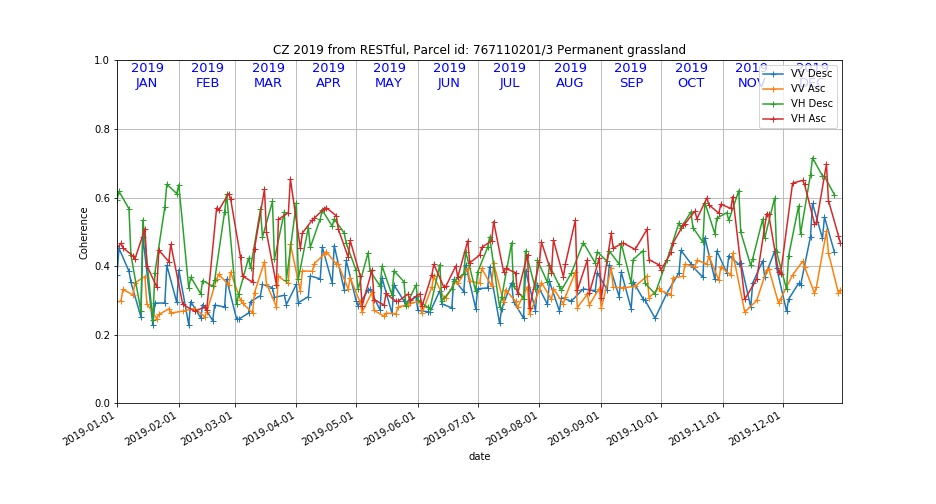

<Response [200]>
http://185.178.85.7/query/parcelById?aoi=cz&year=2019&pid=767110201/3&withGeometry=True
767110201/3 Permanent grassland bs area:19.54
<Response [200]>
http://185.178.85.7/query/parcelTimeSeries?aoi=cz&year=2019&pid=767110201/3&tstype=bs&scl=True&ref=True
COH6 graph saved to file: e:/munka/outreach_2021/CZ/mowing_detection/bs_graphs/rnd50/767110201-3.jpg


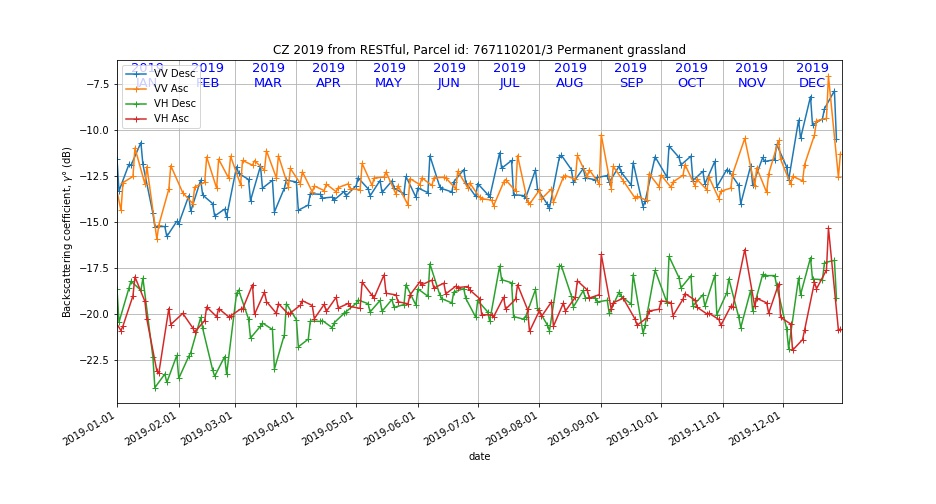

In [6]:
# # Country specific settings - Belgium Wallonie
# ms = "bewa"
# year = 2020
# detection_type = "mowing_detection"
# ptype = ""

# uncomment the following 6 lines if you want to run the restful extract for
# all the parcels in the shapefile below

# vector_file_name = "c:/Users/Csaba/ownCloud/GTCAP/Outreach_2021/MS_direcory/BE-WA/mowing_detection/vector/bewa_2020a_5types_rnd_first_50.shp"
# parcels = geopandas.read_file(vector_file_name)
# parcel_id_column = "id"
# list_of_parcel_ids_to_process = parcels[parcel_id_column].to_list()
# list_of_parcel_ids_to_process.sort()
# selected_parcel_ids = list_of_parcel_ids_to_process


# run the restful extract for the parcel ids listed below
# selected_parcel_ids = (
#     1917042726,
# )

# Country specific settings - Czech Republic 2019
ms = "cz"
year = 2019
detection_type = "mowing_detection"
ptype = ""

# run the restful extract for the parcel ids listed below
selected_parcel_ids = (
    "767110201/3",
)

# General parameters
tstypes = ["s2", "c6","bs"]

# S2 specific parameters
cloud_categories = [0,1,3,8,9,10,11] # 10 is thin cirrus
add_error_bars = True

# S1 specific parameters
separate_orbits = True

plot_figures = True
save_figures = True
display_saved_figures = True
save_csv = True
fixed_date_range = True

#Define your RESTful API username and password
api_user, api_pass = [your_api_username], [your_api_password]

out_base_folder = "e:/munka/outreach_2021"


for parcel_id in selected_parcel_ids:
    for tstype in tstypes:
        out_csv_folder = out_base_folder + "/" + ms + "/" + detection_type + "/csv/" + str(year) + "/" + tstype
        crop, parcel_area_ha_str, url = gts.get_crop_name_and_area(ms,year,parcel_id,api_user, api_pass, ptype)
        print(url)
        print(str(parcel_id) + " " + crop + " " + tstype + " area:" + parcel_area_ha_str)
        
        ### Extract and display S2 NDVI profile
        if tstype == "s2":
            was_error = True
            while was_error:
                url, ts, was_error = gts.get_extracted_data_from_restful(ms, year, parcel_id, api_user, api_pass, tstype, ptype)

            print(url)
            if not ts.empty:
                ts_clean_cloudfree_unique = gts.get_clean_cloudfree_unique_s2_data(ts, cloud_categories)
                if ts_clean_cloudfree_unique.empty:
                    print('Not enough data for parcel with parcel_id='+str(parcel_id))
                else:
                    if plot_figures:
                        saved_NDVI_figure = gts.plot_graph(ms,detection_type,year,ts_clean_cloudfree_unique,crop,out_base_folder,
                                                       parcel_id, add_error_bars, save_figures, fixed_date_range)
                        if save_figures and display_saved_figures:
                            img = Image(saved_NDVI_figure)
                            display(img)
                    if save_csv:
                        gts.save_ndvi_profile_to_csv(ts_clean_cloudfree_unique, out_csv_folder, parcel_id, crop)
            else:
                print("No S2 data for parcel id: " + str(parcel_id))    

        ### Extract and display S1 6-day coherence profile
        elif tstype == "c6" or tstype == "bs":
            was_error = True
            while was_error:
                url, radar_profile_filtered, was_error = gts.get_extracted_data_from_restful(ms, year, parcel_id, api_user, api_pass, 
                                                                         tstype, ptype)
            print(url)
            if not radar_profile_filtered.empty:
                # sort by date
                radar_profile_filtered = radar_profile_filtered.sort_values(by=['date'])
                
                # Then plot the graph and save it to a file
                plot_title = ms.upper() + " " + str(year) + " from RESTful"
                x_start_date = str(year) + "-01-01"
                x_end_date = str(year) + "-12-31"
                
                if tstype == "c6":
                    output_graph_folder = out_base_folder + "/" + ms.upper() + "/" + detection_type + "/coh_graphs/rnd50"
                    if plot_figures:
                        saved_COH_figure = gts.plot_radar_data_orbits_together(output_graph_folder, radar_profile_filtered,
                                                           plot_title, fixed_date_range, x_start_date, x_end_date,
                                                           parcel_id, separate_orbits, crop, save_figures)
                        if save_figures and display_saved_figures:
                            img = Image(saved_COH_figure)
                            display(img)
                    if save_csv:
                        gts.save_radar_profile_to_csv(radar_profile_filtered, out_csv_folder, parcel_id, crop)
                            
                elif tstype == "bs":
                    output_graph_folder = out_base_folder + "/" + ms.upper() + "/" + detection_type + "/bs_graphs/rnd50"
                    if plot_figures:                    
                        saved_BS_figure = gts.plot_radar_bs_data_orbits_together(output_graph_folder, radar_profile_filtered,
                                                   plot_title, fixed_date_range, x_start_date, x_end_date,
                                                   parcel_id, separate_orbits, crop, save_figures)
                        if save_figures and display_saved_figures:
                            img = Image(saved_BS_figure)
                            display(img)
                    if save_csv:
                        gts.save_radar_profile_to_csv(radar_profile_filtered, out_csv_folder, parcel_id, crop)
                            
            else:
                if tstype == "c6":
                    print("No COH data for parcel id: " + str(parcel_id))
                elif tstype == "bs":
                    print("No BS data for parcel id: " + str(parcel_id))
                    

        else:
            print("time series type " + tstype + " is not defined yet")
    
